# Moedl training

Finally! we are uy, español papi, español...
Que si, que ya viene la parte donde entrenamos el modelo. Vamos a mirar que nos podria servir. En un principio nos serviria una regresion Logistica, 

In [2]:
import pandas as pd
import numpy as np

In [3]:
train_lasso = pd.read_csv('../data/model/train_Lasso.csv')
test_lasso = pd.read_csv('../data/model/test_Lasso.csv')
train_pca = pd.read_csv('../data/model/train_PCA.csv')
test_pca = pd.read_csv('../data/model/test_PCA.csv')

`Modelos`

Vamos a probar diferentes modelos. Como buen estadistico (hoy en dia, nombrado cientifico de datos en contra de mi voluntad) dependiendo de la necesidad y los adtos, se usa un modelo u otro. La naturaleza de este ejercicio es clasificacion pero ahora, esto no ssignifica que sea una camisa de fuerza a la hora de casarnos con un modelo. Vamos a escoger uno, el mejor que podamos encontrar aca humildemente. La lista de preselecionados es:

 * XGBosst con SHAP analysis: ¿Motivo? Que belleza ese XGboost. No muy interpretable. Pero si con un analisis de SHAP entonces... Este nos gusta. 
 * Regresion Logistica: Ah, la vieja y confiable RL, nunca falla. Bueno si pero es especialmente querida por su capacidad interpretativa. 
 * Random Forest: un buen bosque aleatorio nunca esta de mas probarlo en estos problemas. BUeno para captiurar cosas no lineales, sin mucho riesgo de sobre ajuste. Malo si tienes una patata de PC a la hora de escribir estas lineas. Spoiler, es mi caso. 
 * LigthGBM: El XGBoost mas rapido y efectivo. Este vale la pena entrenarlo a sabiendas de que se nos pide un modelo para el cual los datos sean escalables. BigData en mente. 
 * SVM: MAquinas de Spoerte vectorial. Support vector Machine. Me gusta el nombre. No muy eficiente a muchos datos y tampoco muy efectivo a la hora de interpretarse. Con PCA nos serviria para tener una prediccion optima. 
 * 

# XgBoost


In [4]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

In [5]:
X_train = train_lasso.drop('incumplimiento', axis=1)
y_train = train_lasso['incumplimiento']
X_test = test_lasso

In [6]:
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [7]:
# Verificar si hay columnas con valores vacíos o nulos en X_test
print("Columnas con valores nulos en X_test:")
print(X_test.isnull().sum().loc[X_test.isnull().sum() > 0])

Columnas con valores nulos en X_test:
Series([], dtype: int64)


In [8]:
import xgboost as xgb

# Crear el modelo XGBoost ajustando scale_pos_weight
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=18.11,  # Ajustar para balancear las clases: de haecr la dificion entre 0.94% / 0.05%
    learning_rate=0.1,       # Reducir el learning rate: Hiperparametros a ajustar
    n_estimators=200,        # Aumentar el número de árboles. Mas hiperparametros a ajustar
    max_depth=4,             # No haytiempo timmy
    random_state=42,
    eval_metric='logloss'
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilidades de clase positiva

# Revisar las predicciones ajustadas
print(f"Predicciones ajustadas: {y_pred[:10]}")
print(f"Probabilidades ajustadas: {y_proba[:10]}")

# Guardar las predicciones
test_lasso['prediccion_incumplimiento'] = y_pred
test_lasso['probabilidad_incumplimiento'] = y_proba

# Exportar el archivo con las predicciones
test_lasso.to_csv('../data/output/test_Lasso_with_predictions.csv', index=False)

print("Predicciones realizadas y guardadas en 'test_Lasso_with_predictions.csv'.")


Predicciones ajustadas: [0 0 1 0 0 0 0 0 0 0]
Probabilidades ajustadas: [0.12374607 0.0590155  0.8349499  0.05243475 0.0248938  0.10487586
 0.05578148 0.16961303 0.00737987 0.0012018 ]
Predicciones realizadas y guardadas en 'test_Lasso_with_predictions.csv'.


`Validacion del modelo`

AUC-ROC: 0.7867
Log-Loss: 0.2777
Matriz de Confusión:
[[87  5]
 [ 5  3]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        92
           1       0.38      0.38      0.38         8

    accuracy                           0.90       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.90      0.90      0.90       100



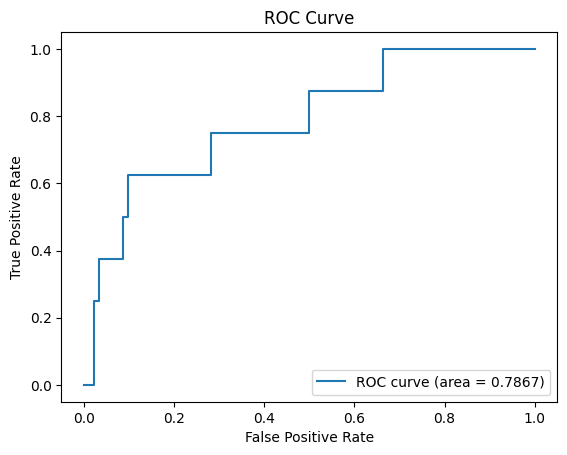

In [9]:
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt

# Cargar el conjunto de validación que contiene la variable objetivo 'incumplimiento'
valid_lasso = pd.read_csv('../data/processed/valid_processed.csv')

# Separar las características y la variable objetivo
X_valid = valid_lasso.drop('incumplimiento', axis=1)
y_valid = valid_lasso['incumplimiento']

# Asegurarnos de que X_valid tenga las mismas columnas que X_train
X_valid = X_train.align(X_valid, join='left', axis=1, fill_value=0)[1]

# Hacer predicciones en el conjunto de validación
y_valid_pred = xgb_model.predict(X_valid)
y_valid_proba = xgb_model.predict_proba(X_valid)[:, 1]

# 1. AUC-ROC
roc_auc = roc_auc_score(y_valid, y_valid_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

# 2. Log-Loss
logloss = log_loss(y_valid, y_valid_proba)
print(f"Log-Loss: {logloss:.4f}")

# 3. Matriz de Confusión
cm = confusion_matrix(y_valid, y_valid_pred)
print("Matriz de Confusión:")
print(cm)

# 4. Precision, Recall, F1-Score
print("Reporte de Clasificación:")
print(classification_report(y_valid, y_valid_pred))

# 5. Curva ROC
fpr, tpr, _ = roc_curve(y_valid, y_valid_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



`Insights:`

1) AUC - ROC: 0.7867
   Sorpendentemente bueno. Este modelo dada esta metria es capaz de capturar informacion relevante puesto que es cercano a uno (escala 0-1, mas cercano a 1 implica mejor estimaciones)

2) Log-Loss: 0.2777
   Un valor relativamente bajo en la perdida logaritmica. Metrica para medir precision incertidumbre. En general, bien

3) Confusion matrix: Aca se eviedncia el problema real. Esta metrica tiene truco dado que lo anteiro dice que el modelo tiene una buena precision y e sutuil sin embargo aca evienciamos que no es un buen modelo para predecir la clase minoritaria, incumplimiento

4) F1- Score: 0.38
   El modelo tiene dificultades para detectar casos de incumplimiento. Estamos llevados llave... ya no pasamos a bancolombia :c

5) Curva ROC: 
   En general detecta un buen patron para separa las clases pero no es perfecta. Seguimos llevados... 

**Conclusiones**
Valdria la pena considerar aumentar el tamaño de la muestra. El valor intrinseco a este modelo esta sesgado por una clase que tiene mayor peso. La otra al no tener suficientes datos (dado que desde el depurado mucha informacion se eliminó) esto generó que no haya suficientes datos en la categoria de interes para poder ejecutar un buen modelo. 

La recomendacion final es, corregir el estado de calidad de la informacion (valores negativos en contreos, fechas, promedios) para luego de eso, tener presente informacion relevante quye pueda nutrir el modelo. Ahora, dada la naturaleza del fenomeno, los datos son relativametne pequeños en la clase de interes. Calibrar esto con **una estrategia de mercado** es vital. No solo hacer tecnicas de bootstraping, subsampling y demas. **Es vital conectar con la estrategia de negocio** para conectar el componente tecnico con el valor asociado a la analitica. 

# Shap interprewtation


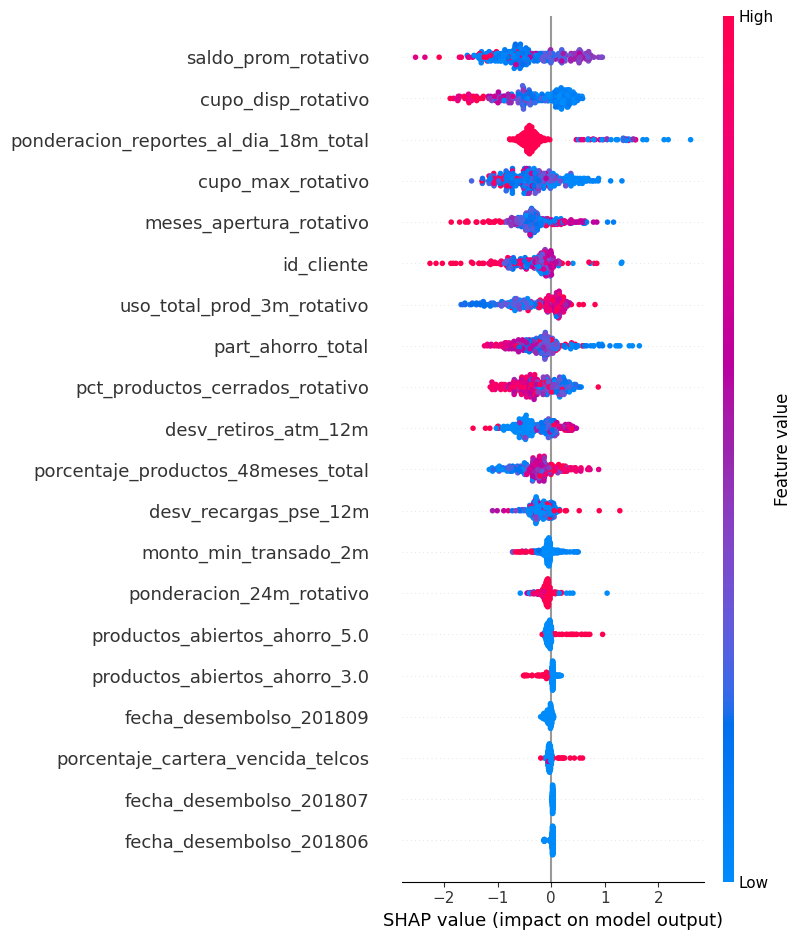

In [11]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


Saldo Promedio Rotativo (saldo_prom_rotativo) es la característica más influyente en la predicción. Un saldo alto reduce la probabilidad de incumplimiento, mientras que un saldo bajo la aumenta.

Cupo Disponible Rotativo (cupo_disp_rotativo) sigue siendo clave, donde un cupo alto reduce la probabilidad de incumplimiento y un cupo bajo la aumenta.

Reportes al día en los últimos 18 meses (ponderacion_reportes_al_dia_18m_total) muestra que tener más reportes al día reduce la probabilidad de incumplimiento (valores altos reducen el riesgo).

Las características menos importantes como fecha_desembolso_201807 tienen un menor impacto en las predicciones del modelo.

# Regresion Logistica

Vamos a intentar capturar informacion tambien con una regresion Logistica. Vamos a signarles probabilidades y con esto, trabajaremos 

AUC-ROC: 0.6766
Log-Loss: 0.2867
Matriz de Confusión:
[[92  0]
 [ 8  0]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        92
           1       0.00      0.00      0.00         8

    accuracy                           0.92       100
   macro avg       0.46      0.50      0.48       100
weighted avg       0.85      0.92      0.88       100



d:\Repositorios\Personales\credit-risk-segmentation\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Repositorios\Personales\credit-risk-segmentation\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Repositorios\Personales\credit-risk-segmentation\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

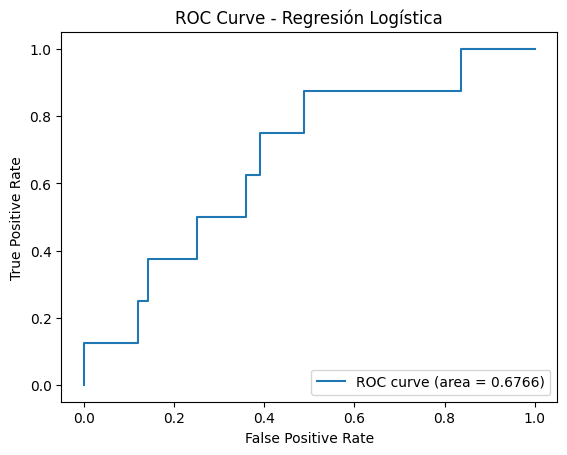

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt

# Separar las características y la variable objetivo del conjunto de validación
valid_lasso = pd.read_csv('../data/processed/valid_processed.csv')
X_valid = valid_lasso.drop('incumplimiento', axis=1)
y_valid = valid_lasso['incumplimiento']

X_train, X_valid = X_train.align(X_valid, join='left', axis=1, fill_value=0)

# Crear y entrenar el modelo de Regresión Logística
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación
y_valid_pred = log_reg.predict(X_valid)
y_valid_proba = log_reg.predict_proba(X_valid)[:, 1]

# Evaluación del modelo de regresión logística

# 1. AUC-ROC
roc_auc = roc_auc_score(y_valid, y_valid_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

# 2. Log-Loss
logloss = log_loss(y_valid, y_valid_proba)
print(f"Log-Loss: {logloss:.4f}")

# 3. Matriz de Confusión
cm = confusion_matrix(y_valid, y_valid_pred)
print("Matriz de Confusión:")
print(cm)

# 4. Precision, Recall, F1-Score
print("Reporte de Clasificación:")
print(classification_report(y_valid, y_valid_pred))

# 5. Curva ROC
fpr, tpr, _ = roc_curve(y_valid, y_valid_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Regresión Logística')
plt.legend(loc="lower right")
plt.show()


En general, Logistic regresion ha tenido un rendimiento peor que XgBoost. 

# Desbalanceo de clase

El desbalanceo de clase es un problema común en la clasificación. En este caso, la clase minoritaria (incumplimiento) es muy pequeña en comparación con la clase mayoritaria (no incumplimiento). Esto puede ser un problema para el modelo, ya que es muy probable que el modelo no aprenda bien la clasificación de esta clase.

Hay varias estrategias para tratar este problema:

1. Oversampling: Duplicar los ejemplos de la clase minoritaria para que tenga la misma cantidad que la clase mayoritaria. Esto puede ser una técnica de aumento de datos.
2. Subsampling: Subsampling implica reducir los datos al tamaño de la clase mas pequeña
3. Bootrsaping

Ahora, siempre que se tenga aceeso a la informacion, es recomendable evitar siempre que se pueda el muestreo artificial. Antes de aplicar algun algoritmo de imputacion de datos, lo recomendable seria primero mirar **calidad de datos** puesto que, depender siempre de algoritmos de imputacion pueden meter varianza y sesgo a un probblema que seria directamente abarcable desde el propio sistema de informacion. 

Si en definitiva no es posible tener mas informacion de la calse pequeña, entonces se recomienda usar alguna de las tecnicas mencionadas o incluso, una regresion de clase (mirar los datos por separado y predecir nuevos datos inventados). Pero incluso asi,  es algo que a regañadientes acepto. 


# Resutlados

Dada la estructura del proyecto, en la carpeta output se guarda el modelado de toda la informacion. Allli tambien se entregan las predicicones con su respectivo grupo de riesgo. 
